In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Download dataset dari kaggle menggunakan API Kaggle.

Untuk dapat menggunakan API Kaggle, perlu menyiapkan file kaggle.json yang merupakan API Token dari akun kaggle.

In [ ]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
! unzip gtsrb-german-traffic-sign.zip

Import Library yang diperlukan

In [8]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import  PIL
from PIL import  ImageEnhance , ImageOps , Image
from matplotlib import pyplot
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

Setting untuk gambar dan plot diagram

In [9]:
plt.rcParams["figure.figsize"] = (16,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")

Menentukan Train dataset, image size dan jumlah kategori

In [10]:
train_path = 'Train'
IMG_HEIGHT = 30
IMG_WIDTH = 30

In [11]:
# Number of Classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

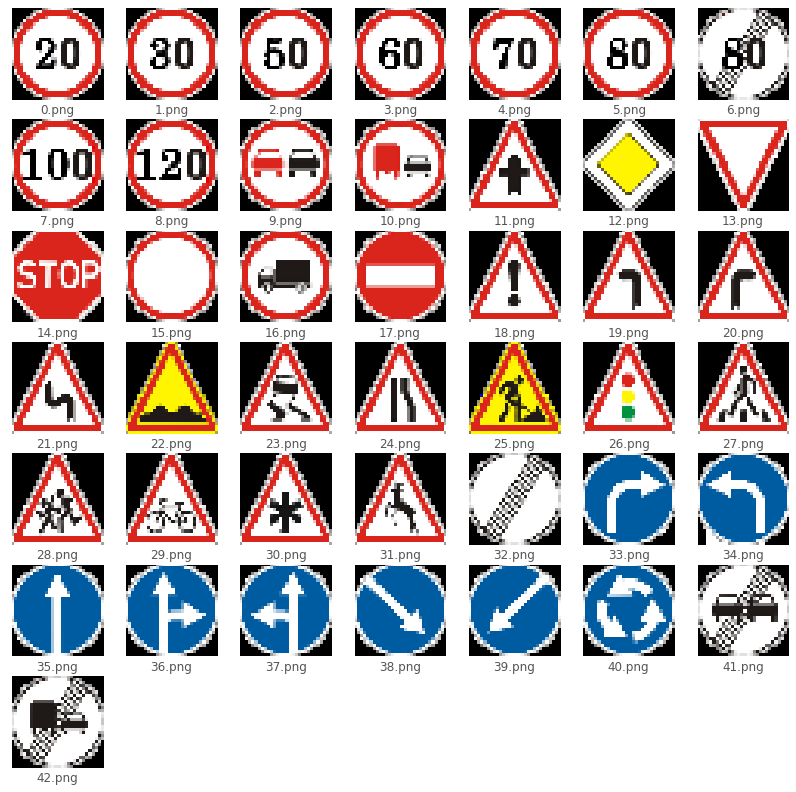

In [12]:
# Visualizing all the different signs
plt.figure(figsize=(14,14))
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = load_img('Meta/'+str(i)+'.png', target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.xlabel(str(i)+'.png')
plt.show()

In [13]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Vehicle > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End of no passing vehicle > 3.5 tons' }

Visualisasi jumlah data per kategori

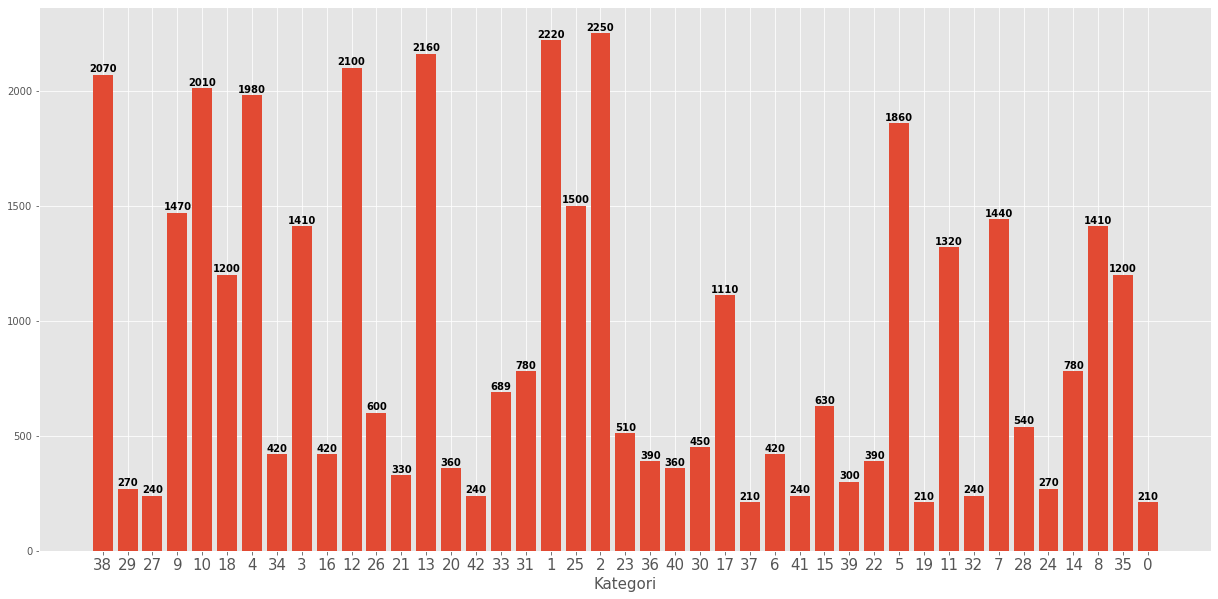

In [64]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(folder)

fig, ax = plt.subplots(figsize=(21,10)) 
ax.bar(class_num, train_number) 
plt.xticks(class_num, rotation='horizontal',fontsize=15)
plt.xlabel("Kategori",fontsize=15)
for i, v in enumerate(train_number):
    ax.text(i,v+10, str(v), ha='center', fontweight='bold')
plt.show()

Mencari jumlah data terkecil dari suatu kategori

In [41]:
min=len(os.listdir('Train/'+str(1)))
for i in range(43):
  if(min>len(os.listdir('Train/'+str(i)))):
    min=len(os.listdir('Train/'+str(i)))
    min_class=str(i)
print("Kategori " + min_class + " adalah kategori dengan jumlah data terkecil yaitu sebesar " + str(min))

Kategori 0 adalah kategori dengan jumlah data terkecil yaitu sebesar 210


Melakukan sort pada kategori berdasarkan jumlah datanya

In [65]:
sorted_class = [x for _,x in sorted(zip(train_number,class_num))]
sorted_train_number = sorted(train_number)
sorted_data = {'Kategori':sorted_class,'Jumlah Data':sorted_train_number}
df_sorted_data = pd.DataFrame(sorted_data)
print(df_sorted_data.to_string(index=False))

Kategori  Jumlah Data
       0          210
      19          210
      37          210
      27          240
      32          240
      41          240
      42          240
      24          270
      29          270
      39          300
      21          330
      20          360
      40          360
      22          390
      36          390
      16          420
      34          420
       6          420
      30          450
      23          510
      28          540
      26          600
      15          630
      33          689
      14          780
      31          780
      17         1110
      18         1200
      35         1200
      11         1320
       3         1410
       8         1410
       7         1440
       9         1470
      25         1500
       5         1860
       4         1980
      10         2010
      38         2070
      12         2100
      13         2160
       1         2220
       2         2250


Mengelompokkan kategori dan memberikan batas jumlah data pada tiap grup kategori.
Kami membagi menjadi 3 grup kategori yaitu sebagai berikut:
- Grup 1 berisi 15 kategori dengan jumlah data 210 per kategori
- Grup 2 berisi 14 kategori dengan jumlah data 420 per kategori
- Grup 3 berisi 14 kategori dengan jumlah data 1320 per kategori

In [86]:
! mkdir 'Grup 1'
! mkdir 'Grup 2'
! mkdir 'Grup 3'

In [87]:
import shutil
counter=0
for folder in sorted_class:
    if(counter<15):
      os.makedirs(os.path.dirname('Grup 1/'+str(folder)), exist_ok=True)
      shutil.copytree('Train/'+str(folder),'Grup 1/'+str(folder))
      counter+=1
    elif(counter<29):
      os.makedirs(os.path.dirname('Grup 2/'+str(folder)), exist_ok=True)
      shutil.copytree('Train/'+str(folder),'Grup 2/'+str(folder))
      counter+=1
    else:
      os.makedirs(os.path.dirname('Grup 3/'+str(folder)), exist_ok=True)
      shutil.copytree('Train/'+str(folder),'Grup 3/'+str(folder))
      counter+=1

In [126]:
def load_data(data_dir, data_num, group):
    images = list()
    labels = list()
    jml_data = list()
    class_num  = list()
    group_class=list()

    if(group==-1):
      group_class=list(map(str,range(0,43)))
    elif(group==1):
      group_class=sorted_class[:15]
    elif(group==2):
      group_class=sorted_class[15:29]
    else:
      group_class=sorted_class[29:43]

    for category in group_class:
        categories = os.path.join(data_dir, str(category))
        class_num.append(category)
        counter=0
        for img in os.listdir(categories):
            if(counter<data_num or data_num==-1):
              img = load_img(os.path.join(categories, img), target_size=(IMG_HEIGHT, IMG_WIDTH))
              image = img_to_array(img)
              images.append(image)
              labels.append(category)
              counter+=1
            else:
              break
        jml_data.append(counter)
    print("Jumlah Kategori dalam " + data_dir + ": "+str(len(jml_data)))
    fig, ax = plt.subplots(figsize=(21,10)) 
    ax.bar(class_num, jml_data) 
    plt.xticks(class_num, rotation='horizontal',fontsize=15)
    plt.xlabel("Kategori",fontsize=15)
    for i, v in enumerate(jml_data):
        ax.text(i,v, str(v), ha='center', fontweight='bold')
    plt.show()
    return images, labels

Jumlah Kategori dalam Grup 3: 14


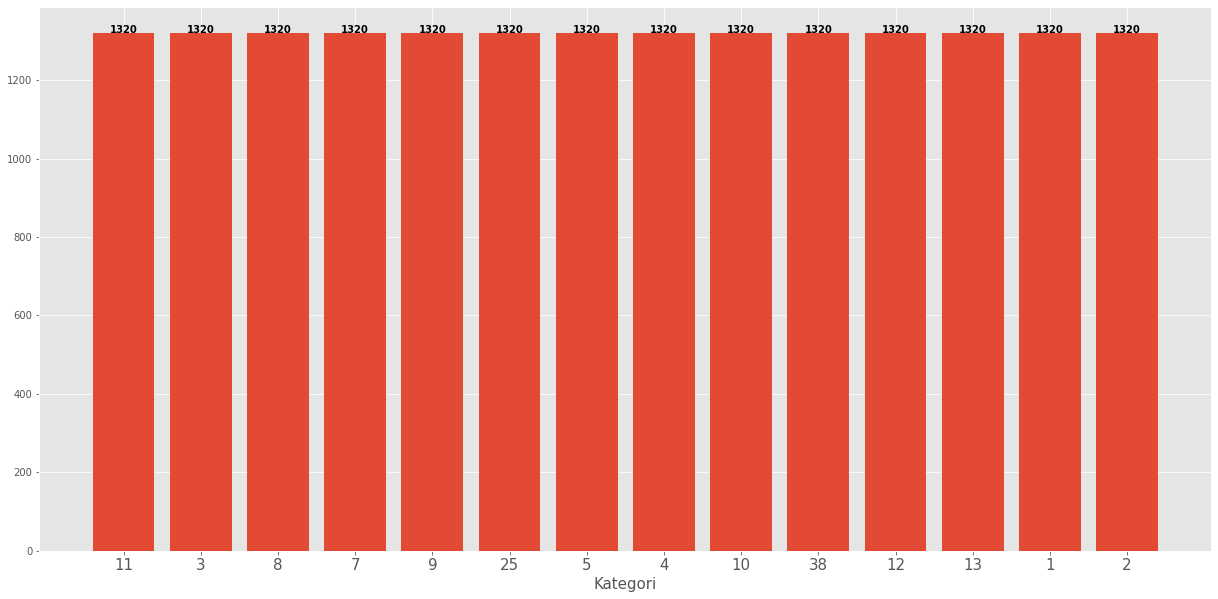

In [180]:
images, labels = load_data('Grup 3',1320,3)

In [182]:
len(images)

18480

In [181]:
labels = to_categorical(labels)

Jumlah Kategori dalam gdrive/MyDrive/Data test Grup 3 (dari internet): 14


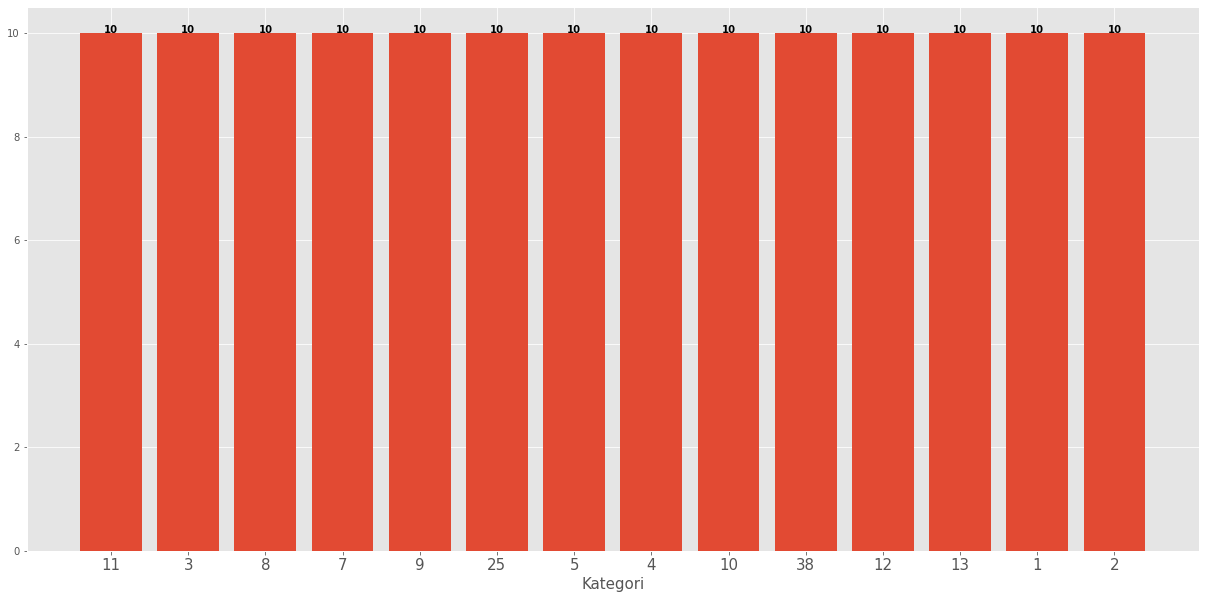

In [183]:
images2, labels2 = load_data('gdrive/MyDrive/Data test Grup 3 (dari internet)',-1,3)

In [184]:
labels2 = to_categorical(labels2)

In [185]:
images2 = np.array(images2)

In [186]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.3)

In [187]:
x_train/=255
x_test/=255
print('x_train shape:',x_train.shape)
print('Number of images in x_train',x_train.shape[0])
print('Number of images in x_test',x_test.shape[0])

x_train shape: (12936, 30, 30, 3)
Number of images in x_train 12936
Number of images in x_test 5544


In [188]:
input_shape=( IMG_HEIGHT, IMG_WIDTH, 3)

In [191]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Third Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(39, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 6, 6, 64)         

In [203]:
history = model.fit(x_train, y_train,validation_split=0.3,epochs=20)

Epoch 1/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0302 - accuracy: 0.9914 - val_loss: 0.0405 - val_accuracy: 0.9928
Epoch 2/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0256 - accuracy: 0.9920 - val_loss: 0.0495 - val_accuracy: 0.9897
Epoch 3/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0285 - accuracy: 0.9901 - val_loss: 0.0687 - val_accuracy: 0.9817
Epoch 4/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0223 - accuracy: 0.9920 - val_loss: 0.0536 - val_accuracy: 0.9876
Epoch 5/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0283 - accuracy: 0.9908 - val_loss: 0.0470 - val_accuracy: 0.9874
Epoch 6/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0582 - val_accuracy: 0.9881
Epoch 7/20
283/283 [==============================] - 13s 46ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0480 - val_accuracy:

In [208]:
model.save('gdrive/MyDrive/ml_model_Grup 3')

INFO:tensorflow:Assets written to: gdrive/MyDrive/ml_model_Grup 3/assets


In [209]:
np.save('gdrive/MyDrive/ml_history_Grup 3.npy',history.history)

In [ ]:
#history=np.load('gdrive/MyDrive/ml_history_30_e30.npy',allow_pickle='TRUE').item()

In [ ]:
#model = keras.models.load_model('gdrive/MyDrive/ml_model_30_e30')

In [206]:
loss, accuracy = model.evaluate(images2, labels2)

print('test set dari internet accuracy: ', accuracy * 100)

5/5 [==============================] - 0s 10ms/step - loss: 994.5741 - accuracy: 0.6357
test set dari internet accuracy:  63.57142925262451


In [205]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

174/174 [==============================] - 2s 12ms/step - loss: 0.0324 - accuracy: 0.9922
test set accuracy:  99.22438859939575


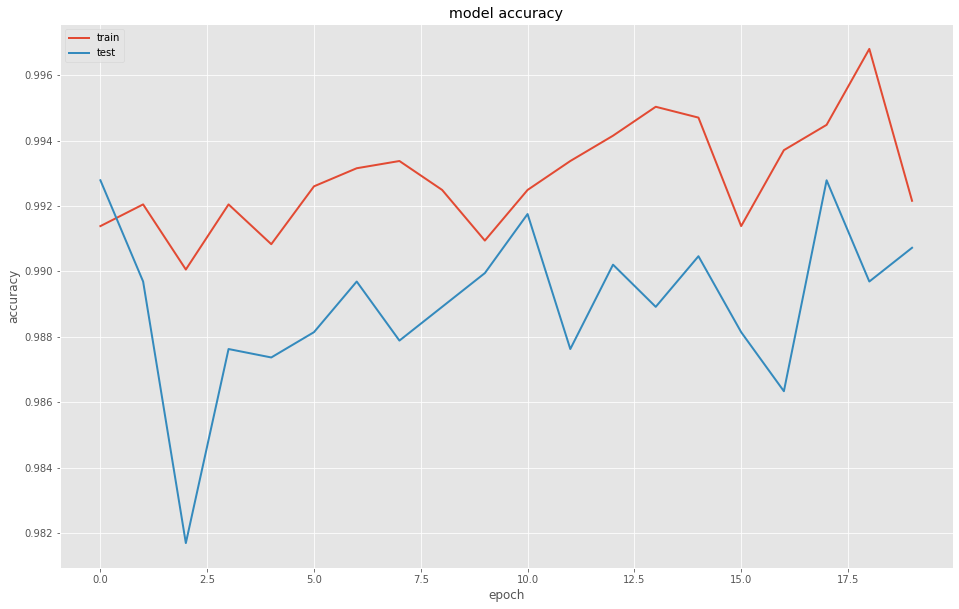

In [207]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
for i in range(36):
  pyplot.subplot(6,6,i+1)
  pyplot.imshow(x_test[i])

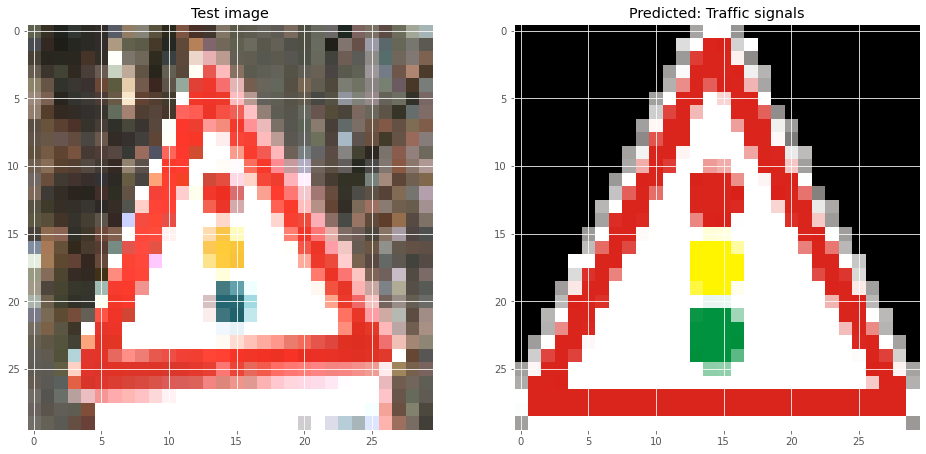

In [ ]:
image_index=345
n = np.array(x_test[image_index])
p = n.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)
index_classes=model.predict(p).argmax()
pred = classes[index_classes]

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow(x_test[image_index])
plt.title("Test image")

plt.subplot(1, 2, 2) # index 2
plt.imshow(load_img('Meta/'+str(index_classes)+'.png', target_size=(IMG_WIDTH, IMG_HEIGHT)))
plt.title("Predicted: {}".format(pred))

plt.show()

In [ ]:
uploaded_img = load_img('tes5.png', target_size=(IMG_HEIGHT, IMG_WIDTH))
uploaded_image = img_to_array(uploaded_img)
uploaded_image/=255

n = np.array(uploaded_image)
p = n.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)
index_classes=model.predict(p).argmax()
pred = classes[index_classes]

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow(uploaded_image)
plt.title("Uploaded image")

plt.subplot(1, 2, 2) # index 2
plt.imshow(load_img('Meta/'+str(index_classes)+'.png', target_size=(IMG_WIDTH, IMG_HEIGHT)))
plt.title("Predicted: {}".format(pred))

plt.show()